# Wholesale Customers
**We create an unsupervised learning model to group the clients of a wholesale distributor based on their annual spending on different products.**

## Data

Source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on 6 product categories.
	

Attribute Information:

* Fresh: annual spending (m.u.) on fresh products (Continuous)
* Milk: annual spending (m.u.) on milk products (Continuous)
* Grocery: annual spending (m.u.) on grocery products (Continuous)
* Frozen: annual spending (m.u.) on frozen products (Continuous)
* Detergents_Paper: annual spending (m.u.) on detergents and paper products (Continuous)
* Delicatessen: annual spending (m.u.) on and delicatessen products (Continuous)
* Channel: customers  Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
* Region: customers  Region Lisnon, Oporto or Other (Nominal)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/wholesome_customers_data.csv")

In [3]:
df.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


## Exploratory Data Analysis

In [5]:
df["Channel"].value_counts()

1    298
2    142
Name: Channel, dtype: int64

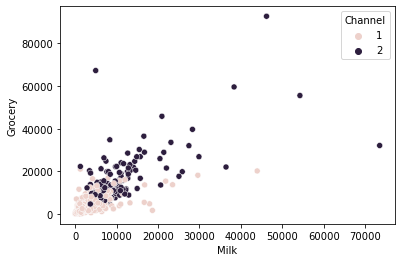

In [6]:
sns.scatterplot(data=df, x="Milk", y="Grocery", hue="Channel");

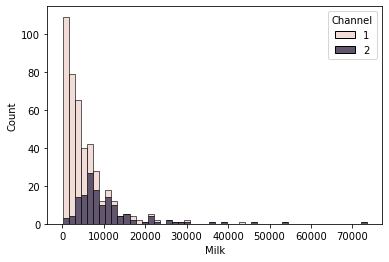

In [7]:
sns.histplot(df, x="Milk", hue="Channel", multiple="stack");

**Correlations between annual spending on different product categories:**

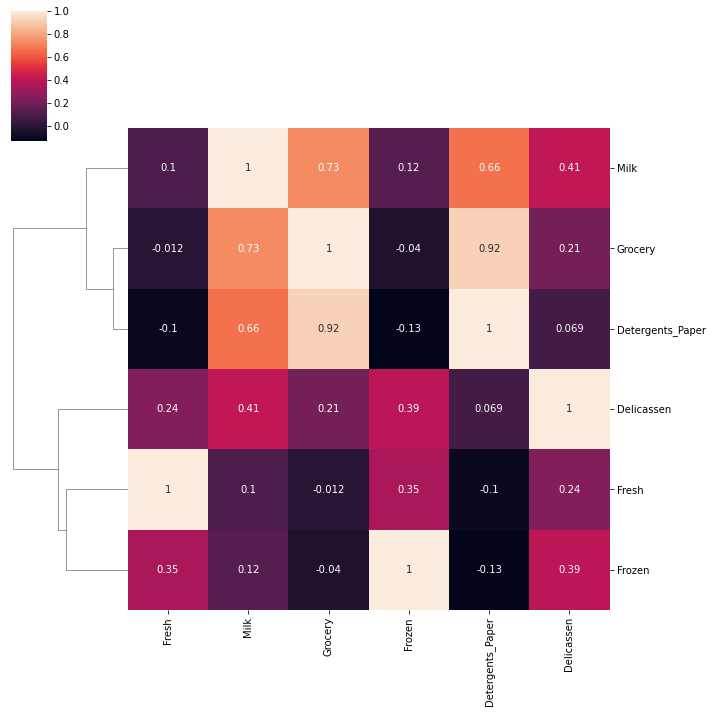

In [8]:
sns.clustermap(
    df.drop(["Region", "Channel"], axis=1).corr(), annot=True, col_cluster=False
);

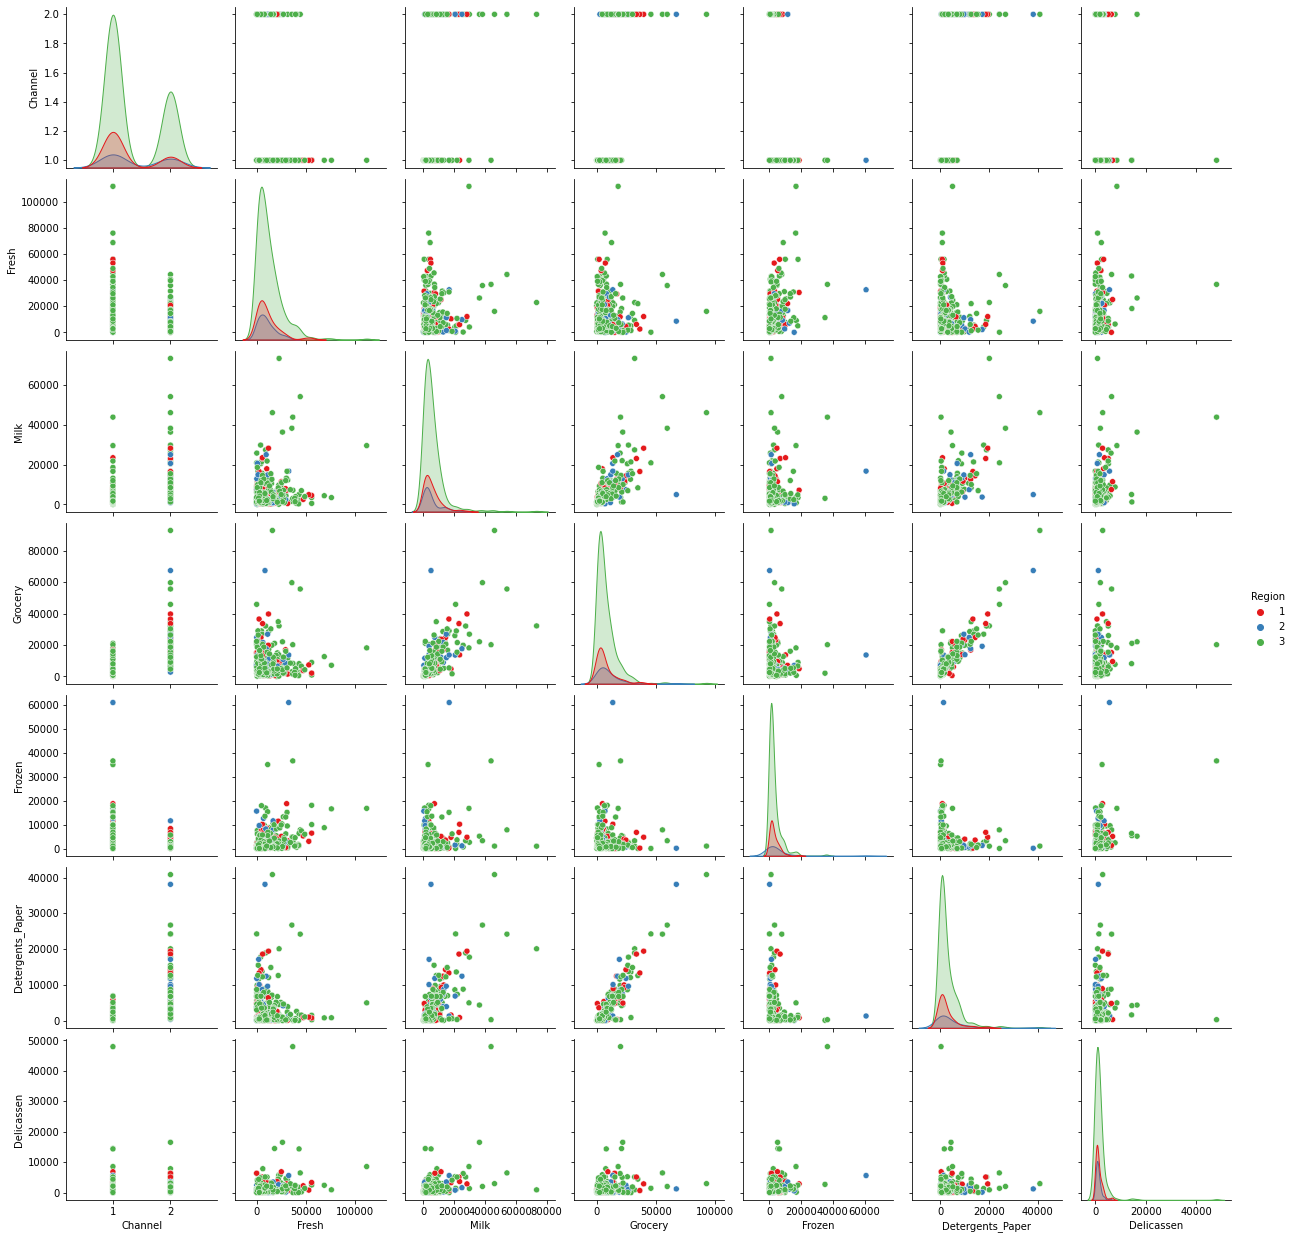

In [9]:
sns.pairplot(df, hue="Region", palette="Set1");

# DBSCAN Machine Learning

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [11]:
from sklearn.cluster import DBSCAN

In [12]:
outlier_percent = list()

eps_range = np.linspace(0.001, 3, 50)
for eps in eps_range:
    # Create model
    model = DBSCAN(eps=eps, min_samples=2 * df.shape[1])
    labels = model.fit_predict(scaled_df)

    # Log percentage of outliers
    outlier_percent.append(100 * np.sum(labels == -1) / len(labels))

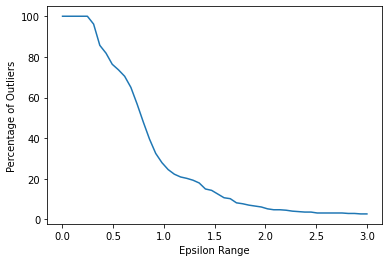

In [13]:
plt.plot(eps_range, outlier_percent)
plt.xlabel("Epsilon Range")
plt.ylabel("Percentage of Outliers");

**As suggested by the graph above, we retrain the DBSCAN model with eps=2.**

In [14]:
model = DBSCAN(eps=2, min_samples=2 * scaled_df.shape[1])
model.fit_predict(scaled_df);

**We create a new column consisting of the DBSCAN labels in the original data frame.**

In [15]:
df["Labels"] = model.labels_
df.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669  9656     7561     214              2674   
1        2       3   7057  9810     9568    1762              3293   
2        2       3   6353  8808     7684    2405              3516   
3        1       3  13265  1196     4221    6404               507   
4        2       3  22615  5410     7198    3915              1777   

   Delicassen  Labels  
0        1338       0  
1        1776       0  
2        7844       0  
3        1788       1  
4        5185       0

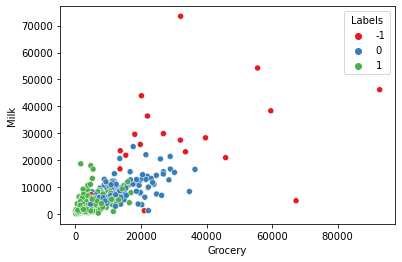

In [16]:
sns.scatterplot(data=df, x="Grocery", y="Milk", hue="Labels", palette="Set1");

**Some points that look like outliers in cluster 0 (blue) above are not outliers, because we're considering only two features. We investigate this further in the following scatterplot.**

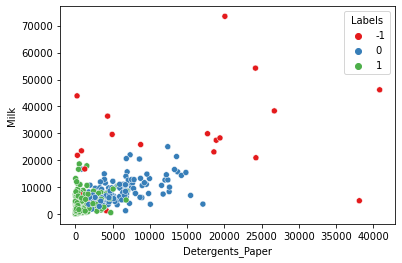

In [17]:
sns.scatterplot(data=df, x="Detergents_Paper", y="Milk", hue="Labels", palette="Set1");

**Next we identify an outlier whose spending on Milk and Detergents_Paper is comparable to the two clusters. The reason for this classification is that the outlier spends much more than the mean of the other categories compared to the two clusters.**

In [18]:
df[
    (df["Labels"] == -1)
    & (df["Detergents_Paper"].between(3000, 5000))
    & (df["Milk"] < 2000)
]

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  \
71        1       3  18291  1266    21042    5373              4173   

    Delicassen  Labels  
71       14472      -1

**The mean value of the money spent on different product categories for each cluster is as follows.**

In [19]:
df.drop(["Channel", "Region"], axis=1).groupby("Labels").mean()

Fresh          Milk       Grocery        Frozen  \
Labels                                                           
-1      27729.920000  22966.960000  26609.600000  11289.640000   
 0       8227.666667   8615.852713  13859.674419   1447.759690   
 1      12326.972028   3023.559441   3655.328671   3086.181818   

        Detergents_Paper   Delicassen  
Labels                                 
-1          11173.560000  6707.160000  
 0           5969.581395  1498.457364  
 1            763.783217  1083.786713

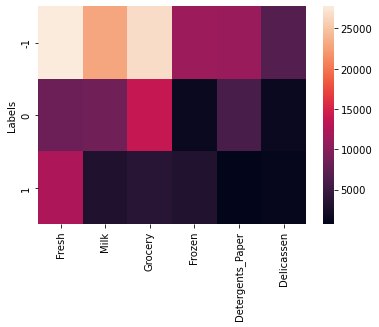

In [20]:
cat_means = df.drop(["Channel", "Region"], axis=1).groupby("Labels").mean()
sns.heatmap(cat_means);

**The heatmap shows that the outliers are spending more money on all products, 
with the most difference being in the fresh, milk, and grocery categories. This can be seen more easily below in the MinMax scaling of the data frame.**

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(cat_means)
scaled_cat_means = pd.DataFrame(
    data=data, columns=cat_means.columns, index=cat_means.index
)
scaled_cat_means

Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
Labels                                                                      
-1      1.000000  1.000000  1.000000  1.000000          1.000000    1.000000
 0      0.000000  0.280408  0.444551  0.000000          0.500087    0.073741
 1      0.210196  0.000000  0.000000  0.166475          0.000000    0.000000

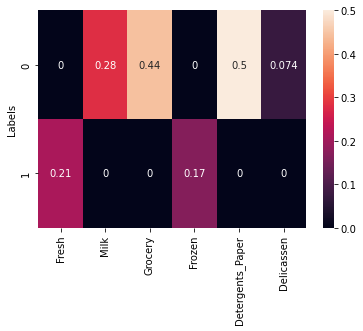

In [22]:
sns.heatmap(scaled_cat_means.iloc[1:], annot=True);

**The two clusters are most different in Detergents_Paper category.**